In [1]:
import torch
import torchvision
import argparse
from torch import nn
from tqdm import tqdm
from utils.net_frame import *
from utils.loss import YoloLoss
from utils.datasets import YoloData
from modules.yolov1 import Yolov1
import torchvision
import matplotlib.pyplot as plt
import numpy as np

**训练debug**

In [2]:
# 与dataset相同的数据处理
transforms = torchvision.transforms.Compose(
    [torchvision.transforms.Normalize(
        mean = [0.485, 0.456, 0.406],
        std  = [0.229, 0.224, 0.225]
    ),torchvision.transforms.Resize((448,448))]
)

In [3]:
yolodata = YoloData("datasets/JPEGImages","datasets/train.txt",transforms = transforms)

Generating targets: 100%|██████████| 13700/13700 [00:03<00:00, 4021.87it/s]


In [11]:
batch_size = 16
train_iter = data.DataLoader(yolodata,batch_size,shuffle = False)

In [12]:
for batch in train_iter:
    X = batch[0]
    Y = batch[1]
    break

In [13]:
net = Yolov1()

In [14]:
num_epochs = 1000
lr = 5e-5
loss_fn = YoloLoss()
trainer = torch.optim.SGD(net.parameters(), lr=lr)
devices_idx = [7]

In [15]:
# 设置设备
if devices_idx == None:
    devices = [try_gpu(i = 0)]
else:
    assert (type(devices_idx == list) and 
            type(devices_idx[0]) == int),"devices_idx must be list of int"
    devices = [torch.device(f"cuda:{i}")
               for i in devices_idx]
print(f"Training on{devices}")

# 多GPU加载网络(当len(devices) == 1时即单卡训练)
net = nn.DataParallel(net, device_ids=devices).to(devices[0])
# 开始训练
loss_plt = []
loop = tqdm(range(num_epochs),desc = "Tiny train",total = num_epochs)
for epoch in loop:
    net.train() # 循环涉及评估，则每次循环前要net.train()

    trainer.zero_grad()

    X = X.to(devices[0])
    Y = Y.to(devices[0])
    y_pred = net(X)
    loss = loss_fn(y_pred,Y)

    loss.sum().backward()
    trainer.step()

    loss_plt.append(loss.sum().item())
    loop.set_postfix({"LOSS" : loss.sum().item() / 4,"lr" : "{:e}".format(trainer.param_groups[0]['lr'])})

Training on[device(type='cuda', index=7)]


Tiny train: 100%|██████████| 1000/1000 [01:10<00:00, 14.23it/s, LOSS=0.205, lr=5.000000e-05]


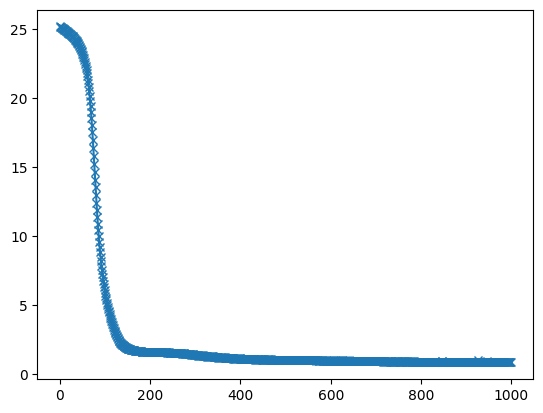

In [16]:
plt.plot(np.arange(len(loss_plt)),loss_plt,marker = 'x')
plt.show()

**预测debug**

In [ ]:
# 2012_001648.jpg 310 186 387 313 0 
# 2011_001416.jpg 114 10 500 242 0 
# 2008_007423.jpg 291 155 403 414 1 
# 2012_002895.jpg 112 58 400 300 0 

['person', 'bird', 'bus', 'car', 'sofa', 'cat', 'chair', 'cow', 'motorbike', 'bicycle', 'bottle', 'diningtable', 'dog', 'pottedplant', 'aeroplane', 'train', 'horse', 'boat', 'tvmonitor', 'sheep']


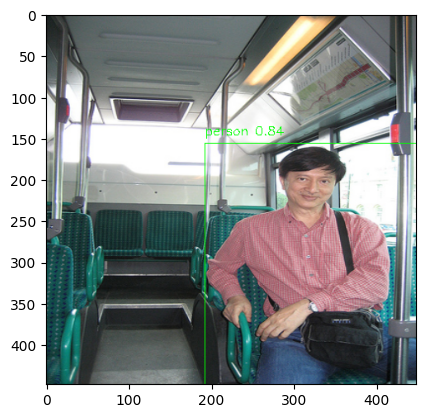

In [25]:
import joblib
from utils.engine import *
import cv2

# 指定图片路径
img_path = "datasets/JPEGImages/2011_000322.jpg"

# 加载class_map
class_map = joblib.load("datasets/class_map.joblib")
VOC_CLASS = [x for x in class_map.keys()]
print(VOC_CLASS)

# 与dataset相同的数据处理
input_tensor = preprocess(img_path,transforms)
out_tensor = model_infer(net,input_tensor,device_idx = 7)
boxes,labels,probs = postprocess(out_tensor,448,448,VOC_CLASS,grid_size = 7,num_bboxes = 2,
                                conf_thresh = 0.5,prob_thresh = 0.5,nms_thresh = 0.5,nb_classes = 20)

img_origin = cv2.imread(img_path)
img_origin = cv2.cvtColor(img_origin,cv2.COLOR_BGR2RGB)
img = cv2.resize(img_origin,(448,448))
for i in range(len(boxes)):
    (x_min,y_min),(x_max,y_max) = boxes[i]
    x_min = x_min.item()
    y_min = y_min.item()
    x_max = x_max.item()
    y_max = y_max.item()
    label_show = f"{labels[i]} {probs[i]:.2f}"
    cv2.rectangle(img, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 1)
    cv2.putText(img, label_show, (int(x_min), int(y_min) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
plt.imshow(img)

In [104]:
print(Y.shape)

torch.Size([4, 30, 7, 7])


In [151]:
Y1 = Y[0].permute(1,2,0) # 对应X[2]，即鸟
print(Y1.shape)

torch.Size([7, 7, 30])


In [152]:
grid_size = 7
cell_size = 1.0 / grid_size
num_bboxes = 2
num_classes = 20

**一、验证dataset的target可以decode回去**

In [153]:
bboxes = Y1[:,:,:10]
classes = Y1[:,:,10:]

In [154]:
boxes = []
labels = []

In [155]:
for i in range(grid_size):
    for j in range(grid_size):
        max_score,max_idx = classes[i,j].max(dim = 0)
        if (max_score > 0):
            labels.append(max_idx.item())
            xc,yc,w,h = bboxes[i,j,:4]
            xc,yc = (j + xc) * cell_size,(i + yc) * cell_size
            xmin,xmax = xc - w / 2,xc + w / 2
            ymin,ymax = yc - h / 2,yc + h / 2
            boxes.append((xmin,ymin,xmax,ymax))

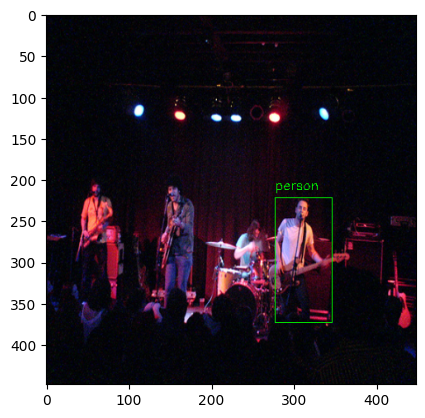

In [157]:
img_origin = cv2.imread("datasets/JPEGImages/2012_001648.jpg")
img_origin = cv2.cvtColor(img_origin,cv2.COLOR_BGR2RGB)
img = cv2.resize(img_origin,(448,448))
for i in range(len(boxes)):
    (x_min,y_min,x_max,y_max) = boxes[i]
    x_min = x_min.item() * 448
    y_min = y_min.item() * 448
    x_max = x_max.item() * 448
    y_max = y_max.item() * 448
    label_show = f"{VOC_CLASS[labels[i]]}"
    cv2.rectangle(img, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 1)
    cv2.putText(img, label_show, (int(x_min), int(y_min) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
plt.imshow(img)

**结论：数据集构造没问题**

**二、用target当out_tensor,测试后处理**

In [159]:
Y1 = Y[0].unsqueeze(0)
print(Y1.shape)

torch.Size([1, 30, 7, 7])


In [160]:
boxes,labels,probs = postprocess(Y1,448,448,VOC_CLASS,grid_size = 7,num_bboxes = 2,
                                conf_thresh = 0.1,prob_thresh = 0.1,nms_thresh = 0.5,nb_classes = 20)

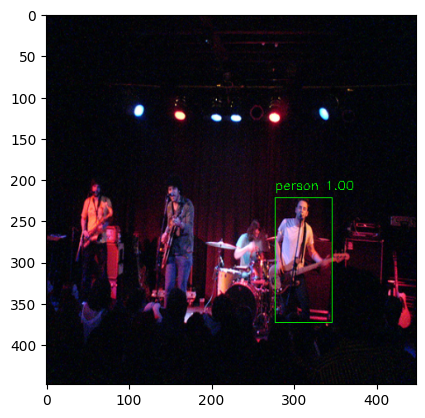

In [161]:
img_origin = cv2.imread(img_path)
img_origin = cv2.cvtColor(img_origin,cv2.COLOR_BGR2RGB)
img = cv2.resize(img_origin,(448,448))
for i in range(len(boxes)):
    (x_min,y_min),(x_max,y_max) = boxes[i]
    x_min = x_min.item()
    y_min = y_min.item()
    x_max = x_max.item()
    y_max = y_max.item()
    label_show = f"{labels[i]} {probs[i]:.2f}"
    cv2.rectangle(img, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 1)
    cv2.putText(img, label_show, (int(x_min), int(y_min) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
plt.imshow(img)

**结论：后处理也没问题**